In [1]:
import numpy as np
import matplotlib.pyplot as plt; plt.rc('font', size=12)
import pandas as pd
from collections import Counter
import seaborn as sns

cmap = sns.color_palette("rocket_r", as_cmap=True)

In [2]:
taxa = ['B_cellulosilyticus_WH2', 
        'B_caccae', 
        'B_vulgatus', 
        'B_thetaiotaomicron', 
        'B_ovatus', 
        'R_obeum', 
        'B_uniformis', 
        'P_distasonis', 
        'C_scindens', 
        'C_aerofaciens', 
        'C_spiroforme', 
        # 'D_longicatena'
        ]

cols = ['#016bff',
        '#b91f1c',
        '#308937',
        '#ff8137',
        '#6f4fc7',
        '#d4b300',
        '#893a2b',
        '#ff6c79',
        '#16c4ff',
        '#766f41',
        '#00c800',
        '#af3261']

pretty_names_dir = {'B_caccae': '$B. caccae$',
                'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
                'B_ovatus': '$B. ovatus$',
                'B_thetaiotaomicron': '$B. thetaiotaomicron$',
                'B_uniformis': '$B. uniformis$',
                'B_vulgatus': '$B. vulgatus$',
                'C_aerofaciens': '$C. aerofaciens$',
                'C_scindens': '$C. scindens$',
                'C_spiroforme': '$C. spiroforme$',
                # 'D_longicatena': '$D. longicatena$',
                'P_distasonis': '$P. distasonis$',
                'R_obeum': '$R. obeum$'}

cols_species_map = dict(zip(taxa, cols))

In [3]:
def presence_absence(x):
    if pd.isna(x):
        return 0
    else:
        return 1
    
def drop_nan(x):
    if pd.isna(x):
        return False
    else:
        return True
    
def calculate_metabolic_distance(table):
    J = np.zeros([len(table.columns), len(table.columns)])
    for i in range(len(table.columns)):
        for j in range(len(table.columns)):
            if i == j:
                J[i,j] = 0
            else:
                set_rep = Counter(table.iloc[:,[i,j]].sum(axis=1))
                J[i,j] = 1 - (set_rep[2]/(set_rep[1]+set_rep[2]))
    return pd.DataFrame(J, index=table.columns, columns=table.columns)

def get_added_information(table):
    J = np.zeros([len(table.columns), len(table.columns)])
    probs = table.apply(sum, axis=1) / len(table.columns)
    for i in range(len(table.columns)):
        for j in range(len(table.columns)):
            if i == j:
                J[i,j] = 0
            else:
                K = table[(table.iloc[:,i] == 0) & (table.iloc[:,j] == 1)].copy().index
                J[i,j] = - np.sum(probs[K]*np.log(probs[K]))
    return pd.DataFrame(J, index=table.columns, columns=table.columns)

def get_weighted_added_information(table):
    J = np.zeros([len(table.columns), len(table.columns)])
    probs = table.copy()
    probs = probs.div(probs.sum(axis=1), axis=0)
    for i in range(len(table.columns)):
        for j in range(len(table.columns)):
            if i == j:
                J[i,j] = 0
            else:
                K = table[table.iloc[:,i] < table.iloc[:,j]].copy().index
                probs_K = probs.loc[K,:].iloc[:,j] - probs.loc[K,:].iloc[:,i]
                J[i,j] = - np.sum(probs_K*np.log(probs_K))
    return pd.DataFrame(J, index=table.columns, columns=table.columns)

def get_aminoacid_metabolism(COG):
    return 'E' in COG

def get_carbohydrate_metabolism(COG):
    return 'G' in COG

# Carbohydrate metabolism

## Metabolic Distance and Metabolic Added Information

In [4]:
dbCAN_sub = []
for taxon in taxa:
    cazymes = pd.read_table(f'dbCAN3/{taxon}/overview.txt', sep='\t', index_col=1)
    cazymes['Species'] = taxon
    cazymes = cazymes[cazymes['#ofTools'] >= 2].loc[:, ['Species']].copy()
    cazymes.reset_index(inplace=True)
    cazymes.set_index('Species', inplace=True)
    cazymes = cazymes['EC#'].str.split('|', expand=True)
    cazymes.reset_index(inplace=True)
    cazymes = cazymes.melt(id_vars='Species', value_name='EC#')
    cazymes.drop(columns='variable', inplace=True)
    cazymes.dropna(inplace=True)
    cazymes = cazymes[cazymes['EC#'] != '-'].copy()
    cazymes.drop_duplicates(subset=['EC#'], inplace=True)
    cazymes.set_index('EC#', inplace=True)
    cazymes.columns = [cazymes['Species'][0]]
    dbCAN_sub.append(cazymes)
dbCAN_sub = pd.concat(dbCAN_sub, axis=1)
dbCAN_sub = dbCAN_sub.applymap(presence_absence)
dbCAN_sub

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
EC#,,,,,,,,,,,
3.2.1.55,1,1,1,1,1,1,1,1,0,0,0
3.2.1.37,1,1,1,1,1,1,1,1,0,1,1
3.2.1.-,1,1,1,1,1,1,1,1,1,1,1
3.2.1.92,1,0,0,0,0,0,1,0,0,0,0
3.2.1.21,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4.2.2.12,0,0,0,0,0,0,0,0,0,0,1
3.2.1.97,0,0,0,0,0,0,0,0,0,0,1
3.2.1.50,0,0,0,0,0,0,0,0,0,0,1


In [5]:
metdist_carbo = calculate_metabolic_distance(dbCAN_sub)
metdist_carbo = metdist_carbo.sort_index(axis=0).sort_index(axis=1)
metdist_carbo.to_csv('metabolic-metrics/metdist_carbo.tsv', sep='\t', index=True, header=True)
metdist_carbo_pretty = metdist_carbo.copy()
metdist_carbo_pretty.columns = metdist_carbo_pretty.columns.map(pretty_names_dir)
metdist_carbo_pretty.index = metdist_carbo_pretty.index.map(pretty_names_dir)
metdist_carbo_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,0.532609,0.426829,0.457831,0.434211,0.438356,0.836364,0.833333,0.721311,0.424242,0.700000
$B. cellulosilyticus$,0.532609,0.000000,0.200000,0.250000,0.272727,0.348315,0.885057,0.892473,0.831579,0.526882,0.806452
$B. ovatus$,0.426829,0.200000,0.000000,0.176471,0.321839,0.237500,0.876543,0.872093,0.820225,0.440476,0.793103
$B. thetaiotaomicron$,0.457831,0.250000,0.176471,0.000000,0.370787,0.271605,0.875000,0.870588,0.790698,0.470588,0.790698
$B. uniformis$,0.434211,0.272727,0.321839,0.370787,0.000000,0.421687,0.859155,0.870130,0.797468,0.428571,0.750000
$B. vulgatus$,0.438356,0.348315,0.237500,0.271605,0.421687,0.000000,0.848485,0.861111,0.815789,0.432432,0.750000
$C. aerofaciens$,0.836364,0.885057,0.876543,0.875000,0.859155,0.848485,0.000000,0.814815,0.823529,0.842105,0.709677
$C. scindens$,0.833333,0.892473,0.872093,0.870588,0.870130,0.861111,0.814815,0.000000,0.820513,0.838710,0.685714
$C. spiroforme$,0.721311,0.831579,0.820225,0.790698,0.797468,0.815789,0.823529,0.820513,0.000000,0.750000,0.772727
$P. distasonis$,0.424242,0.526882,0.440476,0.470588,0.428571,0.432432,0.842105,0.838710,0.750000,0.000000,0.666667


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


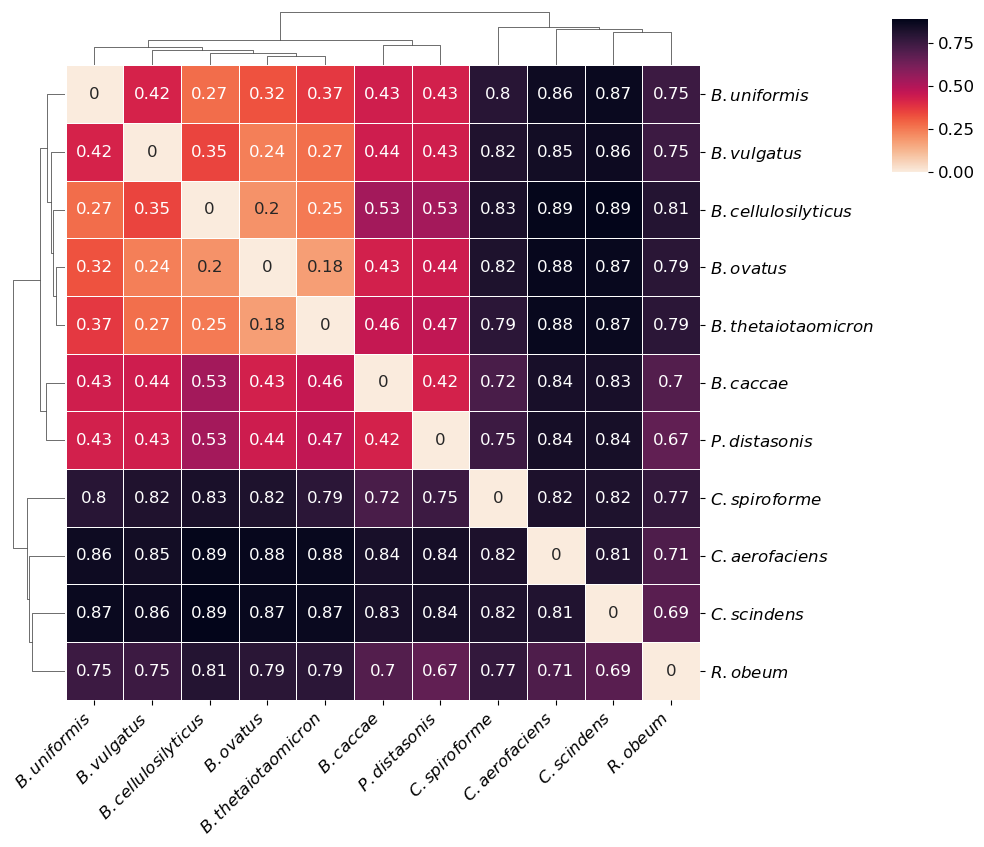

In [6]:
ax = sns.clustermap(metdist_carbo_pretty, 
    cmap=cmap,
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    linewidths=0.5,
    figsize=(9, 9))
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=45, ha='right')
plt.savefig('metabolic-metrics/metdist_carbo.pdf', bbox_inches='tight')
plt.show()

In [7]:
metaddinfo_carbo = get_added_information(dbCAN_sub)
metaddinfo_carbo = metaddinfo_carbo.sort_index(axis=0).sort_index(axis=1)
metaddinfo_carbo.to_csv('metabolic-metrics/metaddinfo_carbo.tsv', sep='\t', index=True, header=True)
metaddinfo_carbo_pretty = metaddinfo_carbo.copy()
metaddinfo_carbo_pretty.columns = metaddinfo_carbo_pretty.columns.map(pretty_names_dir)
metaddinfo_carbo_pretty.index = metaddinfo_carbo_pretty.index.map(pretty_names_dir)
metaddinfo_carbo_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,13.850842,10.822598,10.767870,8.502840,7.711749,0.984591,2.302867,2.844316,4.924144,2.742020
$B. cellulosilyticus$,2.471199,0.000000,1.922589,2.194440,1.308918,1.704598,0.653971,2.302867,3.076735,2.828721,2.742020
$B. ovatus$,1.076555,3.556188,0.000000,1.924786,2.970450,0.684969,0.653971,1.972247,3.174936,1.846327,2.742020
$B. thetaiotaomicron$,1.789294,4.595508,2.692254,0.000000,4.037540,1.397709,0.653971,1.972247,2.476461,2.572572,2.742020
$B. uniformis$,2.323746,6.509467,6.537400,6.837022,0.000000,5.266585,0.653971,2.302867,2.977718,2.739169,2.353714
$B. vulgatus$,3.115812,8.488305,5.835076,5.780348,6.849742,0.000000,0.653971,2.302867,3.836175,3.601666,2.742020
$C. aerofaciens$,11.837824,22.886848,21.253248,20.485780,17.686298,16.103141,0.000000,3.212687,5.841090,12.673559,4.535258
$C. scindens$,11.429665,22.809308,20.845089,20.077621,17.608758,16.025602,1.486252,0.000000,5.242766,12.265400,3.793415
$C. spiroforme$,9.256066,20.868128,19.332729,17.866787,15.568561,14.843861,1.399607,2.527718,0.000000,10.385186,3.967722
$P. distasonis$,4.088409,13.372629,10.756636,10.715412,8.082527,7.361867,0.984591,2.302867,3.137700,0.000000,2.099784


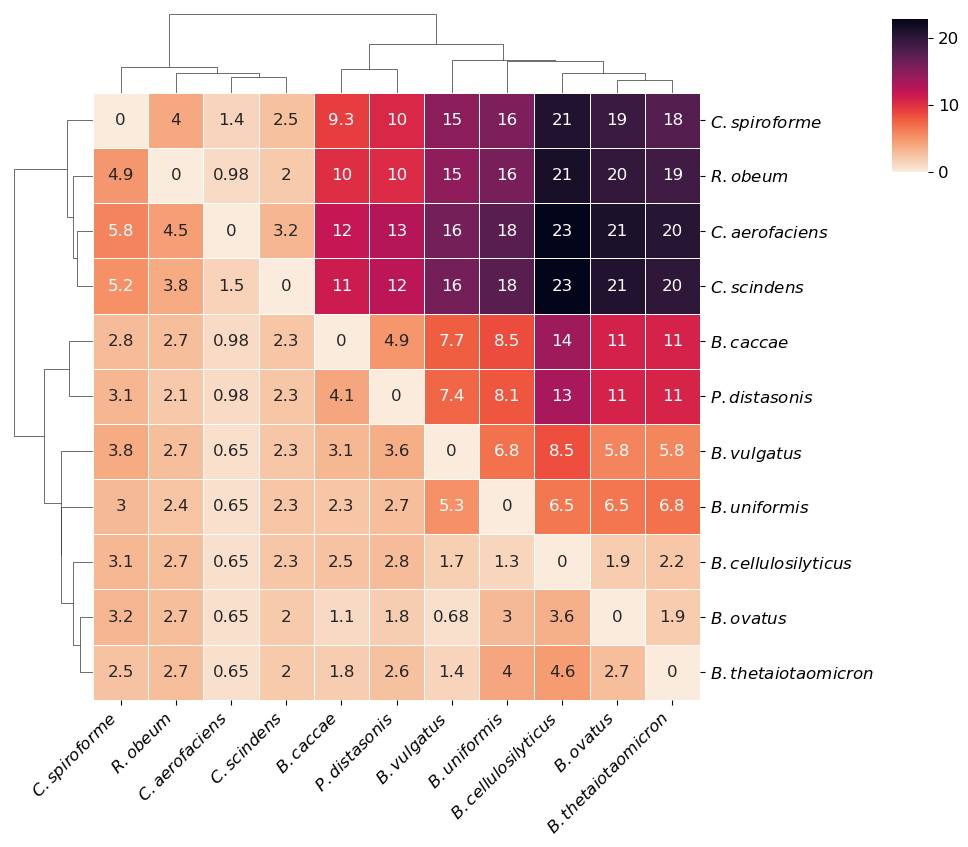

In [8]:
ax = sns.clustermap(metaddinfo_carbo_pretty, 
    metric= 'chebyshev', 
    cmap=cmap,
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5)
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=45, ha='right')
plt.savefig('metabolic-metrics/metaddinfo_carbo.pdf', bbox_inches='tight')
plt.show()

# Amino Acid Metabolism

 ## Metabolic distance and Metabolic Added Information

In [9]:
eggNOG = []
for taxon in taxa:
    aminoacid_metabolism = pd.read_table(f'eggNOG/{taxon}_eggNOG.tsv', index_col=0, skiprows=4, skipfooter=3, engine='python')
    aminoacid_metabolism['Species'] = taxon
    aminoacid_metabolism = aminoacid_metabolism[aminoacid_metabolism['COG_category'].apply(get_aminoacid_metabolism)].copy()
    aminoacid_metabolism = aminoacid_metabolism[aminoacid_metabolism['EC'] != '-'].copy()
    aminoacid_metabolism.set_index('EC', inplace=True)
    aminoacid_metabolism = aminoacid_metabolism.loc[:,['Species']].copy()
    aminoacid_metabolism.reset_index(inplace=True)
    aminoacid_metabolism.set_index('Species', inplace=True)
    aminoacid_metabolism = aminoacid_metabolism['EC'].str.split(',', expand=True)
    aminoacid_metabolism.reset_index(inplace=True)
    aminoacid_metabolism = aminoacid_metabolism.melt(id_vars='Species', value_name='EC')
    aminoacid_metabolism.drop(columns='variable', inplace=True)
    aminoacid_metabolism.dropna(inplace=True)
    aminoacid_metabolism.drop_duplicates(subset=['EC'], inplace=True)
    aminoacid_metabolism.set_index('EC', inplace=True)
    aminoacid_metabolism.columns = [aminoacid_metabolism['Species'][0]]
    eggNOG.append(aminoacid_metabolism)
eggNOG = pd.concat(eggNOG, axis=1)
eggNOG = eggNOG.applymap(presence_absence)
eggNOG 

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
EC,,,,,,,,,,,
4.3.2.1,1,1,1,1,1,1,1,1,1,1,0
2.7.2.11,1,1,1,1,1,0,1,1,0,1,1
1.2.1.41,1,1,1,1,1,1,1,1,1,1,1
2.1.3.11,1,1,1,1,1,0,1,1,0,0,0
1.2.1.11,1,1,1,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1.1.1.399,0,0,0,0,0,0,0,0,0,1,0
2.4.2.17,0,0,0,0,0,0,0,0,0,1,0
1.1.1.41,0,0,0,0,0,0,0,0,0,1,0


In [10]:
metdist_amino = calculate_metabolic_distance(eggNOG)
metdist_amino = metdist_amino.sort_index(axis=0).sort_index(axis=1)
metdist_amino.to_csv('metabolic-metrics/metdist_amino.tsv', sep='\t', index=True, header=True)
metdist_amino_pretty = metdist_amino.copy()
metdist_amino_pretty.columns = metdist_amino_pretty.columns.map(pretty_names_dir)
metdist_amino_pretty.index = metdist_amino_pretty.index.map(pretty_names_dir)
metdist_amino_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,0.177966,0.082569,0.090909,0.163793,0.152542,0.595238,0.544715,0.878505,0.255639,0.541353
$B. cellulosilyticus$,0.177966,0.000000,0.119658,0.142857,0.133333,0.182540,0.627737,0.582090,0.889831,0.312500,0.525180
$B. ovatus$,0.082569,0.119658,0.000000,0.097345,0.152542,0.141667,0.610687,0.562500,0.883929,0.270073,0.557971
$B. thetaiotaomicron$,0.090909,0.142857,0.097345,0.000000,0.144068,0.148760,0.613636,0.576923,0.884956,0.275362,0.561151
$B. uniformis$,0.163793,0.133333,0.152542,0.144068,0.000000,0.184000,0.611940,0.553846,0.878261,0.290780,0.507353
$B. vulgatus$,0.152542,0.182540,0.141667,0.148760,0.184000,0.000000,0.605839,0.559701,0.883333,0.255319,0.545455
$C. aerofaciens$,0.595238,0.627737,0.610687,0.613636,0.611940,0.605839,0.000000,0.524272,0.865854,0.651316,0.522124
$C. scindens$,0.544715,0.582090,0.562500,0.576923,0.553846,0.559701,0.524272,0.000000,0.855422,0.582192,0.463636
$C. spiroforme$,0.878505,0.889831,0.883929,0.884956,0.878261,0.883333,0.865854,0.855422,0.000000,0.887218,0.900000
$P. distasonis$,0.255639,0.312500,0.270073,0.275362,0.290780,0.255319,0.651316,0.582192,0.887218,0.000000,0.549020


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


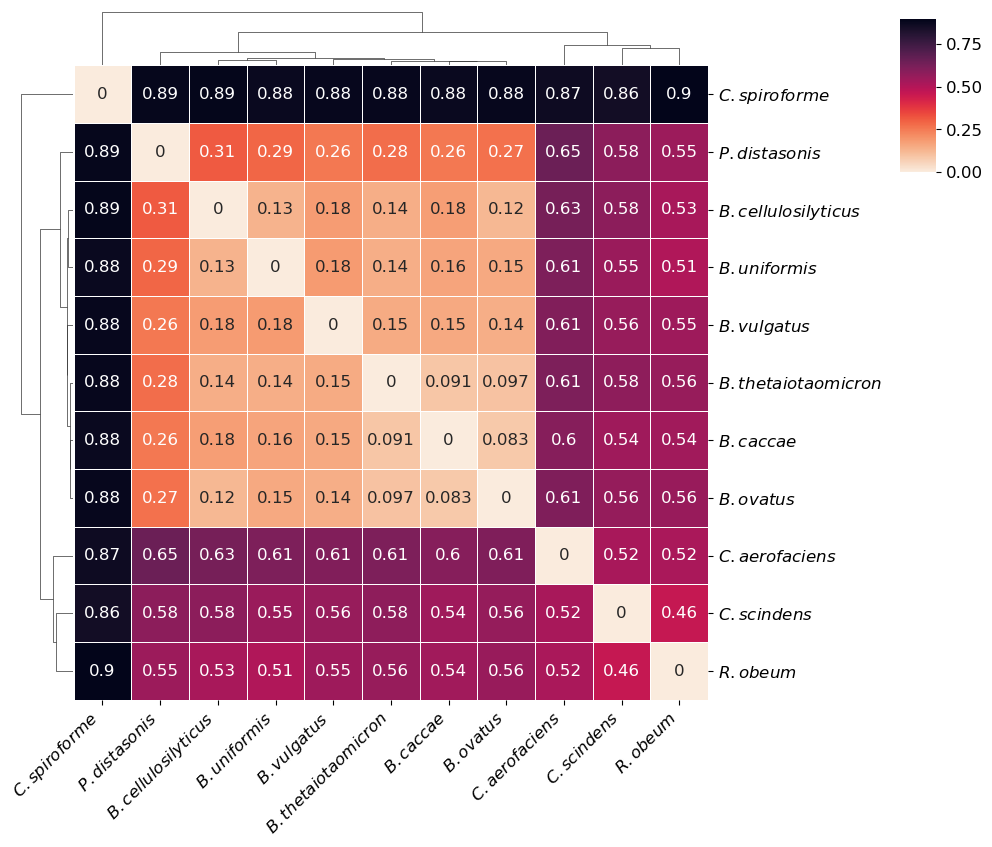

In [11]:
ax = sns.clustermap(metdist_amino_pretty, 
    cmap=cmap, 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(9, 9),
    linewidths=0.5,
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=45, ha='right')
plt.savefig('metabolic-metrics/metdist_amino.pdf', bbox_inches='tight')
plt.show()

In [12]:
metaddinfo_amino = get_added_information(eggNOG)
metaddinfo_amino = metaddinfo_amino.sort_index(axis=0).sort_index(axis=1)
metaddinfo_amino.to_csv('metabolic-metrics/metaddinfo_amino.tsv', sep='\t', index=True, header=True)
metaddinfo_amino_pretty = metaddinfo_amino.copy()
metaddinfo_amino_pretty.columns = metaddinfo_amino_pretty.columns.map(pretty_names_dir)
metaddinfo_amino_pretty.index = metaddinfo_amino_pretty.index.map(pretty_names_dir)
metaddinfo_amino_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,5.240177,2.415603,2.657431,4.494241,5.083259,7.089355,6.466381,1.761524,8.428403,9.832297
$B. cellulosilyticus$,1.740116,0.000000,1.372261,2.023962,2.032525,4.100883,7.089355,6.423389,1.761524,8.491691,8.041286
$B. ovatus$,0.735710,3.192429,0.000000,1.996192,3.465148,4.067670,7.089355,6.466381,1.761524,8.148524,9.832297
$B. thetaiotaomicron$,0.646017,3.512608,1.664671,0.000000,3.160636,4.059608,7.089355,6.754008,1.761524,8.082561,9.789305
$B. uniformis$,1.820344,2.858689,2.471143,2.498153,0.000000,4.514796,6.758735,5.805142,1.430905,8.237259,7.753659
$B. vulgatus$,0.735710,3.253394,1.400014,1.723473,2.841144,0.000000,6.094431,5.437287,1.430905,6.523252,8.448854
$C. aerofaciens$,12.908109,16.408170,14.588002,14.919524,15.251387,16.260735,0.000000,6.172696,1.597043,19.631914,9.279828
$C. scindens$,11.963742,15.420810,13.643635,14.262783,13.976400,15.282197,5.851302,0.000000,1.242693,17.634722,8.212499
$C. spiroforme$,16.888376,20.388437,18.568269,18.899791,19.231654,20.905306,10.905141,10.872185,0.000000,23.612181,15.756084
$P. distasonis$,1.019629,4.582977,2.419643,2.685201,3.502383,3.462027,6.404385,4.728587,1.076555,0.000000,7.075850


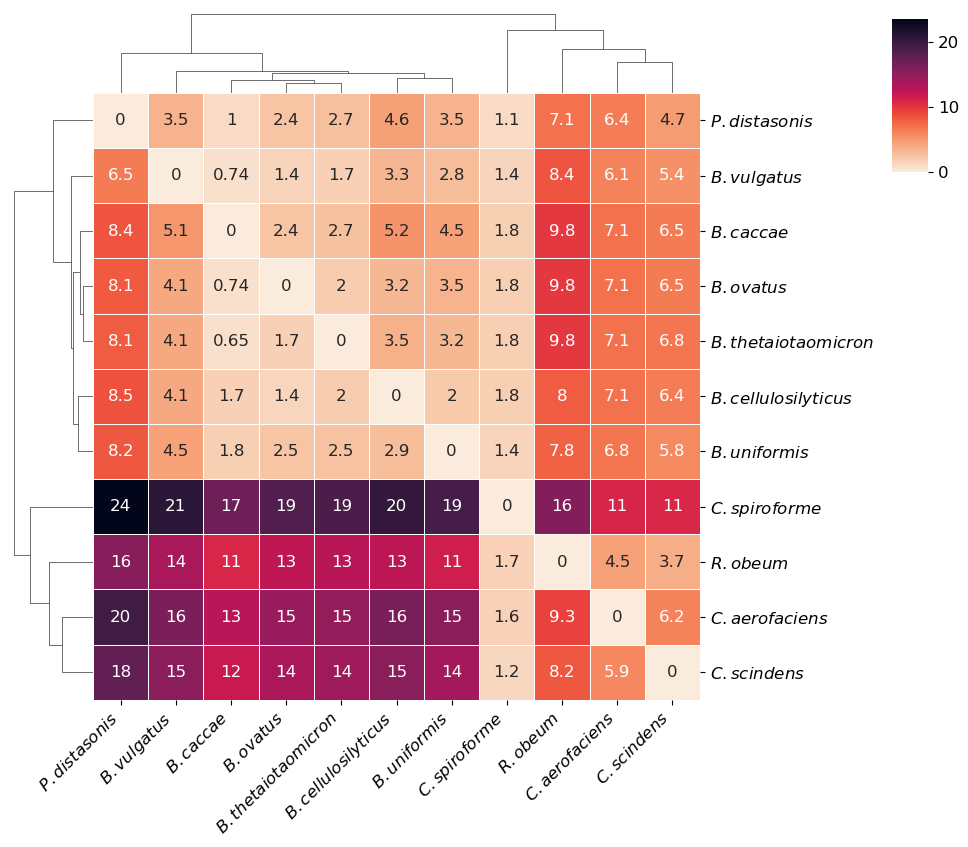

In [13]:
ax = sns.clustermap(metaddinfo_amino_pretty, 
    metric= 'chebyshev', 
    cmap=cmap, 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5)
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=45, ha='right')
plt.savefig('metabolic-metrics/metaddinfo_amino.pdf', bbox_inches='tight')
plt.show()

# Carbohydrate and Amino Acid Metabolism

 ## Metabolic Distance and Metabolic Added Information

In [14]:
dbCAN_sub_eggNOG = pd.concat([dbCAN_sub, eggNOG], axis=0)
dbCAN_sub_eggNOG

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
3.2.1.55,1,1,1,1,1,1,1,1,0,0,0
3.2.1.37,1,1,1,1,1,1,1,1,0,1,1
3.2.1.-,1,1,1,1,1,1,1,1,1,1,1
3.2.1.92,1,0,0,0,0,0,1,0,0,0,0
3.2.1.21,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1.1.1.399,0,0,0,0,0,0,0,0,0,1,0
2.4.2.17,0,0,0,0,0,0,0,0,0,1,0
1.1.1.41,0,0,0,0,0,0,0,0,0,1,0
2.1.3.6,0,0,0,0,0,0,0,0,0,1,0


In [15]:
metdist_carbo_amino = calculate_metabolic_distance(dbCAN_sub_eggNOG)
metdist_carbo_amino = metdist_carbo_amino.sort_index(axis=0).sort_index(axis=1)
metdist_carbo_amino.to_csv('metabolic-metrics/metdist_carbo_amino.tsv', sep='\t', index=True, header=True)
metdist_carbo_amino_pretty = metdist_carbo_amino.copy()
metdist_carbo_amino_pretty.columns = metdist_carbo_amino_pretty.columns.map(pretty_names_dir)
metdist_carbo_amino_pretty.index = metdist_carbo_amino_pretty.index.map(pretty_names_dir)
metdist_carbo_amino_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,0.333333,0.230366,0.248705,0.270833,0.261780,0.668508,0.639344,0.821429,0.311558,0.590674
$B. cellulosilyticus$,0.333333,0.000000,0.154589,0.189573,0.192308,0.251163,0.727679,0.709251,0.863850,0.396624,0.637931
$B. ovatus$,0.230366,0.154589,0.000000,0.131313,0.224390,0.180000,0.712264,0.686916,0.855721,0.334842,0.648889
$B. thetaiotaomicron$,0.248705,0.189573,0.131313,0.000000,0.241546,0.198020,0.712264,0.693023,0.844221,0.349776,0.648889
$B. uniformis$,0.270833,0.192308,0.224390,0.241546,0.000000,0.278846,0.697561,0.671498,0.845361,0.339450,0.594340
$B. vulgatus$,0.261780,0.251163,0.180000,0.198020,0.278846,0.000000,0.684729,0.665049,0.857143,0.316279,0.613953
$C. aerofaciens$,0.668508,0.727679,0.712264,0.712264,0.697561,0.684729,0.000000,0.584615,0.853448,0.703349,0.562500
$C. scindens$,0.639344,0.709251,0.686916,0.693023,0.671498,0.665049,0.584615,0.000000,0.844262,0.658654,0.517241
$C. spiroforme$,0.821429,0.863850,0.855721,0.844221,0.845361,0.857143,0.853448,0.844262,0.000000,0.842640,0.861111
$P. distasonis$,0.311558,0.396624,0.334842,0.349776,0.339450,0.316279,0.703349,0.658654,0.842640,0.000000,0.582160


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


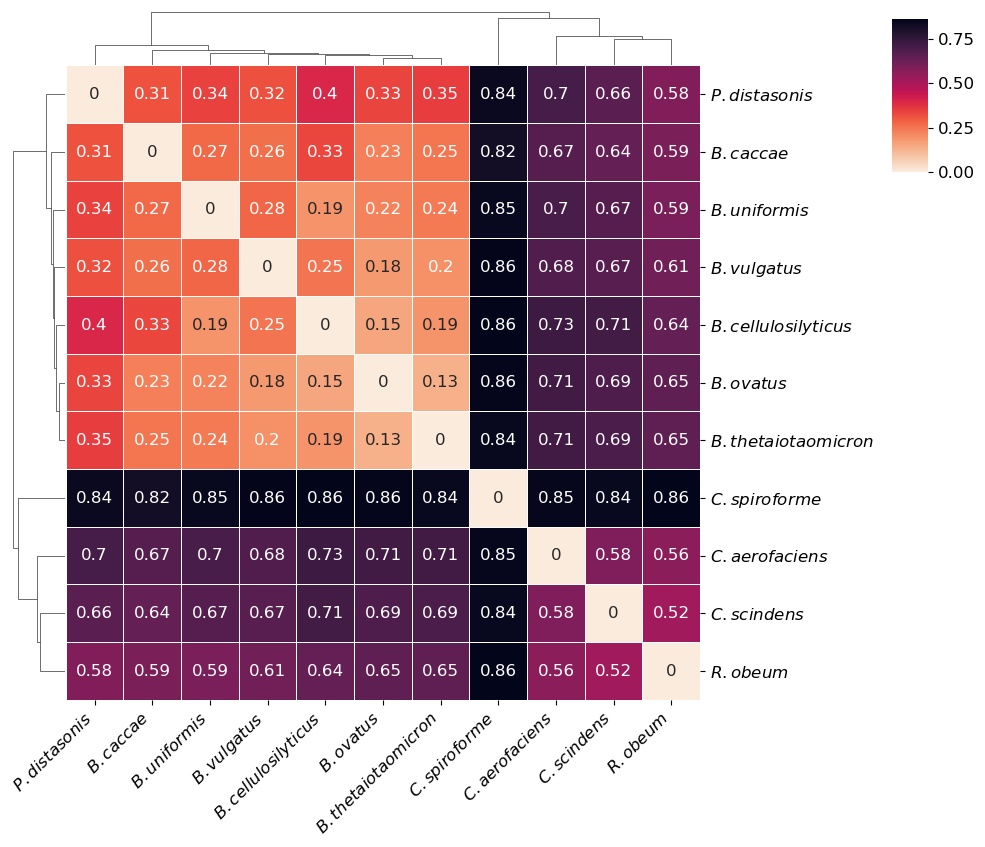

In [16]:
ax = sns.clustermap(metdist_carbo_amino_pretty, 
    cmap=cmap, 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(9, 9),
    linewidths=0.5
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=45, ha='right')
plt.savefig('metabolic-metrics/metdist_carbo_amino.pdf', bbox_inches='tight')
plt.show()

In [17]:
metaddinfo_carbo_amino = get_added_information(dbCAN_sub_eggNOG)
metaddinfo_carbo_amino = metaddinfo_carbo_amino.sort_index(axis=0).sort_index(axis=1)
metaddinfo_carbo_amino.to_csv('metabolic-metrics/metaddinfo_carbo_amino.tsv', sep='\t', index=True, header=True)
metaddinfo_carbo_amino_pretty = metaddinfo_carbo_amino.copy()
metaddinfo_carbo_amino_pretty.columns = metaddinfo_carbo_amino_pretty.columns.map(pretty_names_dir)
metaddinfo_carbo_amino_pretty.index = metaddinfo_carbo_amino_pretty.index.map(pretty_names_dir)
metaddinfo_carbo_amino_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,20.862927,14.642255,14.993540,12.997081,14.731102,8.073946,8.769248,4.605840,13.352547,12.574317
$B. cellulosilyticus$,4.211315,0.000000,3.294850,4.382587,3.341443,5.969667,7.743326,8.726255,4.838259,11.320412,10.783305
$B. ovatus$,1.812264,7.116472,0.000000,4.085163,6.435598,5.284680,7.743326,8.438628,4.936460,9.994851,12.574317
$B. thetaiotaomicron$,2.435311,8.475971,4.356925,0.000000,7.198176,5.825172,7.743326,8.726255,4.237985,10.655133,12.531325
$B. uniformis$,4.511945,11.507919,10.780452,11.271268,0.000000,12.085330,7.412707,8.108009,4.408622,10.976429,10.107373
$B. vulgatus$,3.851522,11.741699,7.235090,7.503821,9.690886,0.000000,6.748402,7.740154,5.267079,10.124918,11.190873
$C. aerofaciens$,25.113788,41.434781,37.613159,37.341397,32.937685,34.667825,0.000000,9.385383,7.438133,32.305473,13.815086
$C. scindens$,24.071216,40.679835,36.570587,36.586452,31.895113,33.921702,7.647509,0.000000,6.485459,30.210077,12.315868
$C. spiroforme$,26.822251,43.706282,39.982861,39.012625,35.110170,38.363070,12.614702,13.399902,0.000000,34.307321,20.033760
$P. distasonis$,5.475892,20.095369,14.948187,15.336707,11.584910,13.127843,7.388976,7.031454,4.214255,0.000000,9.175634


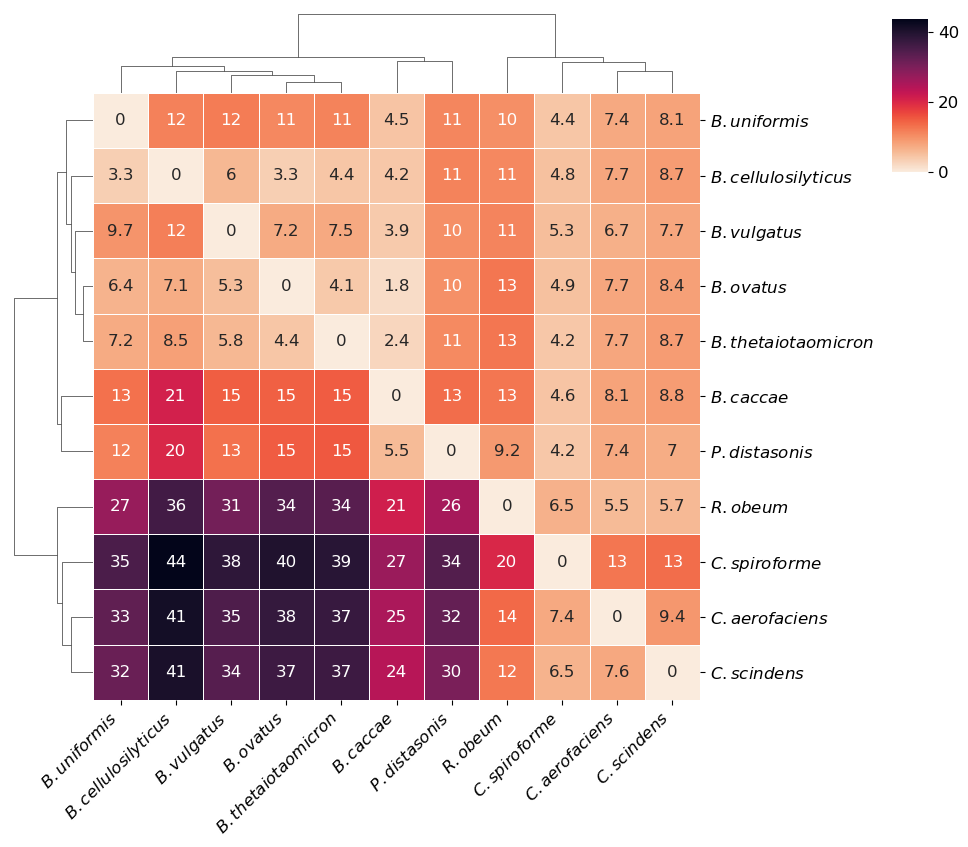

In [18]:
ax = sns.clustermap(metaddinfo_carbo_amino_pretty, 
    metric= 'chebyshev', 
    cmap=cmap, 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=45, ha='right')
plt.savefig('metabolic-metrics/metaddinfo_carbo_amino.pdf', bbox_inches='tight')
plt.show()

# Guided

In [29]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int = exp_mcnulty.loc[:,['EC']]
ecs_int = ecs_int['EC'].str.split('; ', expand=True)
ecs_int.reset_index(inplace=True)
ecs_int = ecs_int.melt(id_vars='Index', value_name='EC')
ecs_int = ecs_int.dropna()
ecs_int = ecs_int['EC'].values
ecs_int

array(['3.6.1.13', '3.2.1.18', '3.2.1.11', '3.1.3.2', '3.6.3.21',
       '3.6.3.2', '1.17.1.4', '3.5.3.12', '3.5.4.4', '2.7.1.53',
       '4.3.1.17', '3.2.2.23', '2.7.2.1', '2.1.1.104', '4.1.1.31',
       '3.4.21.96', '3.5.4.2', '2.7.3.9', '3.5.1.18', '2.7.1.56',
       '2.7.7.12', '1.4.1.3', '6.3.5.6', '3.1.1.5', '1.11.1.10',
       '2.4.1.157', '4.1.1.48', '1.1.1.1', '5.1.3.22', '4.3.1.18',
       '1.1.1.219', '3.5.99.2', '1.2.7.5', '4.2.1.24', '3.4.19.-',
       '3.6.3.4', '1.2.1.10', '4.4.1.1', '1.21.4.3', '1.21.4.2',
       '1.97.1.9', '1.1.1.60', '2.7.2.2', '2.1.3.3', '1.8.1.9',
       '1.1.1.159', '3.5.3.6', '3.5.1.1', '3.2.1.50', '3.2.1.35',
       '4.1.3.36', '3.5.1.41', '5.1.1.4', '1.21.4.1', '1.1.1.14',
       '2.2.1.9', '1.3.1.34', '1.1.1.103', '2.7.1.162', '2.7.7.27',
       '1.2.5.1', '1.1.1.94', '1.1.99.28', '2.4.1.87', '5.4.2.9',
       '2.1.1.72', '1.17.7.1', '4.2.2.-', '2.3.3.1', '6.3.4.14',
       '3.6.3.16', '3.1.21.4', '3.1.3.62', '6.6.1.2', '3.2.1.24',
       '3.5

In [51]:
eggNOG = []
for taxon in taxa:
    aminoacid_metabolism = pd.read_table(f'eggNOG/{taxon}_eggNOG.tsv', index_col=0, skiprows=4, skipfooter=3, engine='python')
    aminoacid_metabolism['Species'] = taxon
    aminoacid_metabolism = aminoacid_metabolism[aminoacid_metabolism['EC'] != '-'].copy()
    aminoacid_metabolism.set_index('EC', inplace=True)
    aminoacid_metabolism = aminoacid_metabolism.loc[:,['Species']].copy()
    aminoacid_metabolism.reset_index(inplace=True)
    aminoacid_metabolism.set_index('Species', inplace=True)
    aminoacid_metabolism = aminoacid_metabolism['EC'].str.split(',', expand=True)
    aminoacid_metabolism.reset_index(inplace=True)
    aminoacid_metabolism = aminoacid_metabolism.melt(id_vars='Species', value_name='EC')
    aminoacid_metabolism.drop(columns='variable', inplace=True)
    aminoacid_metabolism.dropna(inplace=True)
    aminoacid_metabolism.drop_duplicates(subset=['EC'], inplace=True)
    aminoacid_metabolism.set_index('EC', inplace=True)
    aminoacid_metabolism.columns = [aminoacid_metabolism['Species'][0]]
    eggNOG.append(aminoacid_metabolism)
eggNOG = pd.concat(eggNOG, axis=1)
eggNOG = eggNOG.applymap(presence_absence)
eggNOG 

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
EC,,,,,,,,,,,
4.3.2.1,1,1,1,1,1,1,1,1,1,1,0
2.4.2.10,1,1,1,1,1,1,1,1,1,1,1
2.1.1.297,1,1,1,1,1,1,1,1,1,1,1
1.1.1.193,1,1,1,1,1,1,1,1,0,0,0
2.5.1.31,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3.1.26.8,0,0,0,0,0,0,0,0,0,0,1
4.1.1.50,0,0,0,0,0,0,0,0,0,0,1
3.4.21.96,0,0,0,0,0,0,0,0,0,0,1


In [52]:
ecs = eggNOG[eggNOG.index.isin(ecs_int)]
ecs

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
EC,,,,,,,,,,,
2.7.2.1,1,1,1,1,1,1,1,1,1,1,1
5.3.1.4,1,1,1,1,1,1,1,0,0,0,0
2.6.1.37,1,1,1,1,1,0,1,1,0,0,0
4.2.2.20,1,1,0,1,1,0,1,0,0,0,0
3.2.1.4,1,0,0,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1.21.4.4,0,0,0,0,0,0,0,0,1,0,0
3.5.3.6,0,0,0,0,0,0,0,0,0,1,0
4.1.1.31,0,0,0,0,0,0,0,0,0,1,0


In [55]:
metaddinfo_ecs_int = get_added_information(ecs)
metaddinfo_ecs_int = metaddinfo_ecs_int.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ecs_int.to_csv('metabolic-metrics/metaddinfo_ecs_int.tsv', sep='\t', index=True, header=True)
metaddinfo_ecs_int_pretty = metaddinfo_ecs_int.copy()
metaddinfo_ecs_int_pretty.columns = metaddinfo_ecs_int_pretty.columns.map(pretty_names_dir)
metaddinfo_ecs_int_pretty.index = metaddinfo_ecs_int_pretty.index.map(pretty_names_dir)
metaddinfo_ecs_int_pretty

,$B. caccae$,$B. cellulosilyticus$,$B. ovatus$,$B. thetaiotaomicron$,$B. uniformis$,$B. vulgatus$,$C. aerofaciens$,$C. scindens$,$C. spiroforme$,$P. distasonis$,$R. obeum$
$B. caccae$,0.000000,5.065411,4.547692,4.570662,4.288478,4.052835,5.809504,9.365585,3.306084,3.967216,6.637070
$B. cellulosilyticus$,2.540853,0.000000,2.471216,2.710408,1.315819,3.630805,5.478884,9.393355,3.522948,3.578381,7.283087
$B. ovatus$,0.905873,1.353956,0.000000,2.169528,1.859574,2.759306,5.314699,9.158407,3.401756,2.833832,6.760512
$B. thetaiotaomicron$,0.358390,1.022694,1.599074,0.000000,0.934770,2.218982,5.314699,8.870780,3.141899,2.276883,6.472885
$B. uniformis$,1.801414,1.353313,3.014328,2.659978,0.000000,3.245716,5.645319,9.559789,2.783509,2.975357,6.831275
$B. vulgatus$,2.132033,4.234561,4.480322,4.510452,3.811978,0.000000,5.286929,8.891445,3.114129,3.053923,6.472885
$C. aerofaciens$,11.248219,13.442158,14.395233,14.965687,13.571098,12.646446,0.000000,6.450154,1.974809,11.544544,4.194117
$C. scindens$,10.165671,12.718000,13.600312,13.883139,12.846940,11.612334,1.811525,0.000000,1.810624,10.410012,1.991542
$C. spiroforme$,12.827106,15.568529,16.564596,16.875193,14.791596,14.555953,6.057115,10.531559,0.000000,13.011703,7.638859
$P. distasonis$,3.675060,5.810784,6.183494,6.196999,5.170265,4.682569,5.813672,9.317769,3.198525,0.000000,7.207500


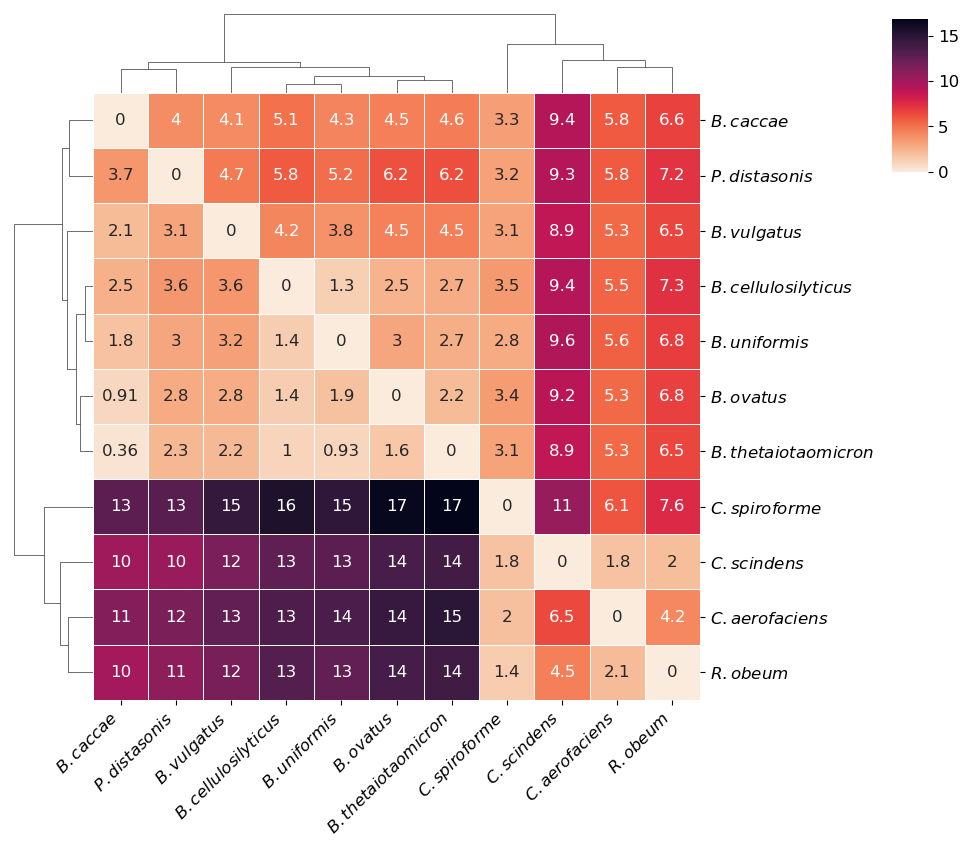

In [56]:
ax = sns.clustermap(metaddinfo_ecs_int_pretty, 
    metric= 'chebyshev', 
    cmap=cmap, 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=45, ha='right')
plt.savefig('metabolic-metrics/metaddinfo_ecs_int.pdf', bbox_inches='tight')
plt.show()